/usr/lib/python2.7/dist-packages/pandas/io/parsers.py:1070: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


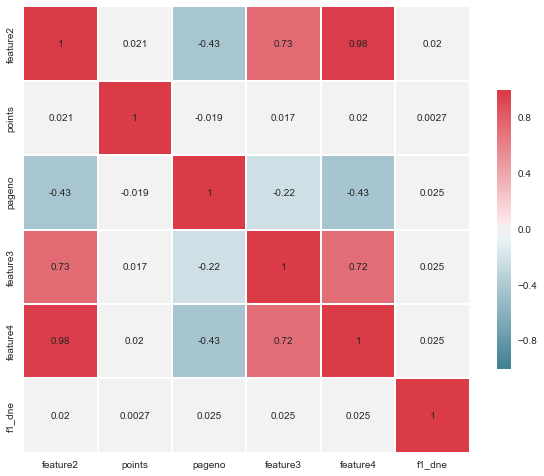

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
%matplotlib inline

data = pd.read_csv('dataset.csv')

# Add a column for the cases where the variable feature1 was not in the data
# we also note that there were 7211 missing values for the variable points of a totoal number of 434041 datapoints
# these entries were dropped in the analysis. 
data['f1_dne'] = pd.isnull(data.feature1)

# Expand variable category into 18 binary variables to see if any categories are highly correlated to each orther
# or the other variables. This doesn't have explicit functionality, but the code was left in for illustrative
# purposes.
temp_dfs = [data]

temp_df = pd.get_dummies(data['category'])
temp_dfs.append(temp_df)

df = pd.concat(temp_dfs, axis=1)
# Continue normal processing

# plot correlation matrix
sns.set()

corr = data.corr()
data.drop('f1_dne', axis = 1,inplace=True)
f, ax = plt.subplots(figsize = (10,10))
cmap = sns.diverging_palette(220,10, as_cmap = True)

sns.heatmap(corr,annot=True, cmap = cmap, square = True,
             linewidth =0.5, cbar_kws={"shrink": 0.5}, ax = ax)

plt.savefig('corr_1.png', bbox_inches='tight')

/usr/lib/python2.7/dist-packages/pandas/core/generic.py:1830: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  self[name] = value


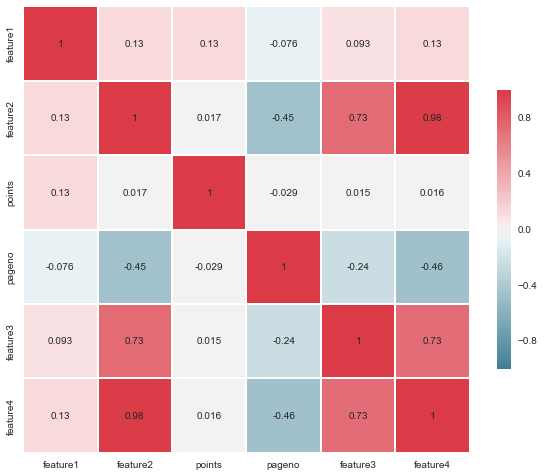

In [2]:
# Since feature1 was present in "2016-03-18 12:00:00", evaluate whether this variavle was strongly correlated with
# others during this period

sns.set()

data2 = data.ix[df['date'] == "2016-03-18 12:00:00"]
data2.feature1 = data2.feature1.astype(int)

corr = data2.corr()

f, ax = plt.subplots(figsize = (10,10))
cmap = sns.diverging_palette(220,10, as_cmap = True)

sns.heatmap(corr,annot=True, cmap = cmap, square = True,
             linewidth =0.5, cbar_kws={"shrink": 0.5}, ax = ax)

plt.savefig('corr_2.png', bbox_inches='tight')

In [3]:
# Part B. Determine the number of times an advertisement appears in the dataset
# Since we don't have unique advertisement identifiers, we need to determine a proxy for this, 
# then we need to identify what features will be applicable 
#
# First look at a random advertiser id
print data.ix[data['id'] == '-?6|G-4-06-']

data = data.drop('feature1', 1)

       feature1  feature2  points category     city                 date  \
32492      True         5     225        N  Jericho  2016-03-18 12:00:00   
72963      True         5     225        N  Jericho  2016-03-18 12:00:00   
104952     True         5     225        N  Jericho  2016-03-18 12:00:00   
117204     True         5     225        N  Jericho  2016-03-18 12:00:00   
195492     True         5     225        N  Jericho  2016-03-18 12:00:00   
236701      NaN         5     224        N  Jericho  2016-02-12 12:00:00   
262864      NaN         5     224        N  Jericho  2016-02-12 12:00:00   
293810      NaN         5     224        N  Jericho  2016-02-12 12:00:00   
345647      NaN         5     224        N  Jericho  2016-02-12 12:00:00   
374381      NaN         5     224        N  Jericho  2016-02-12 12:00:00   
412022      NaN         5     224        N  Jericho  2016-02-12 12:00:00   

                 id  pageno feature3 feature4  
32492   -?6|G-4-06-       8     True   

Since feature1 was observed to have a low correlation with multiple predictors, and, at least for advertiser -?6|G-4-06- entries exist in both dates, this feature can be omitted. 

We now need to find an example (if it exists) of an advertiser that has two clearly different advertisements. To do this, start by finding the advertiser with the most advertisements.

In [4]:
topIds =list(df['id'].value_counts().index)

data.ix[data['id'] == topIds[0]].sort(['city', 'category'], ascending=[True, True]).to_csv('top_ids.csv')

Looking through this file, we see examples that have the same id, date, class and different values in all other fields. So this suggests the only to safely group on ad id is to have unique: feature2, categoty, city, id, feature3 and feature4. If we had additional information, we may be able to do processing that allows for the same add to run in different cities which, while intuitive, we cannot be sure is true.

For each unique advertisement, average points and pageno should be added for each advertisement, however they will be
omitted here to simplify analysis.

In [5]:
# Group the data by our own constructed advertisment id, then drop irrelevant fields and expand the category feature
# in the same way as was done in the first cell

groupedDF = data.groupby(['feature2','category', 'city', 'id', 'feature3', 'feature4'], 
                         as_index=False).size().reset_index()

groupedDF.columns = ['feature2','category', 'city', 'id', 'feature3', 'feature4', 'count']

groupedDF = groupedDF.drop('city', 1)
groupedDF = groupedDF.drop('id', 1)

temp_dfs = [groupedDF]

temp_df = pd.get_dummies(groupedDF['category'])
temp_dfs.append(temp_df)

df = pd.concat(temp_dfs, axis=1)

df.drop('category', axis = 1,inplace=True)

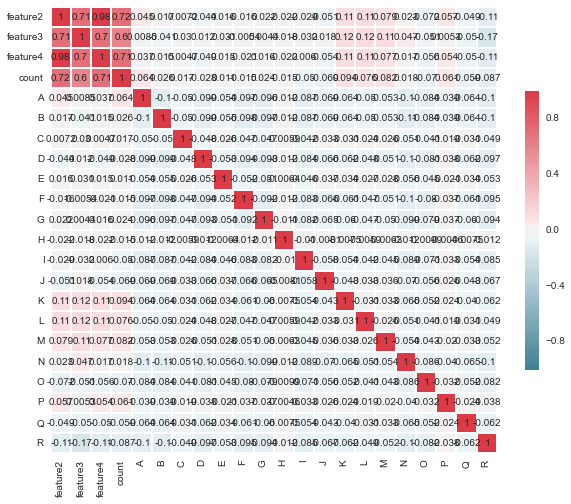

In [6]:
# Again, check for correlations, see if we can determine the variable with the highest magnitude correlation to the 
# response variable
corr = df.corr()
f, ax = plt.subplots(figsize = (10,10))
cmap = sns.diverging_palette(220,10, as_cmap = True)

sns.heatmap(corr,annot=True, cmap = cmap, square = True,
             linewidth =0.5, cbar_kws={"shrink": 0.5}, ax = ax)

In [7]:
# Fit OLS model to each variable. See which covariate gives the lowest training average square loss.

from sklearn.linear_model import LinearRegression

features =list(df.columns[df.columns != 'count'])

scores = {}

for feature in features: 
    reduced = LinearRegression(fit_intercept = True)
    reduced.fit(df.ix[:, df.columns == feature],df['count'])
    preds_train = reduced.predict(df.ix[:, df.columns == feature])
    scores[feature] = ((df['count'] - preds_train) ** 2).sum()/len(df['count'])
    
sortedSC = sorted(scores, key = scores.get)
sortedValues = sorted(scores.values())

print sortedSC
print sortedValues
    

['feature2', 'feature4', 'feature3', 'K', 'R', 'M', 'L', 'O', 'J', 'A', 'P', 'Q', 'I', 'D', 'B', 'G', 'N', 'C', 'H', 'F', 'E']
[8.3984928807006511, 8.5710729368503866, 11.146088293470726, 17.179691162901705, 17.202378369879291, 17.215463269680857, 17.231331607672381, 17.247890982413516, 17.250209560082066, 17.261780759100297, 17.267437837282408, 17.272255716957289, 17.289005326153756, 17.318216106730329, 17.32030012305945, 17.322660150455523, 17.326600447061384, 17.32738268747395, 17.328163249445609, 17.328260695368073, 17.329998245125083]


In [8]:
# Part C, determine the best predictor of an advertiser's minimum page number across all of their advertisements
# to accomplish this, we add a new field after each entry "is_min" which is 1 if the entry(s) = min(pagno) of the 
# subscriber and 0 otherwise. To do this, we first identify the min pageno value for each advertiser. 

data['min_pageno'] = data.groupby(['id'])['pageno'].transform(min)
data['is_min'] = data['pageno'] == data['min_pageno']


In [9]:
# Expand category variable (see cell 1) and then drop some irrelevant variables

temp_dfs = [data]

temp_df = pd.get_dummies(data['category'])
temp_dfs.append(temp_df)

df = pd.concat(temp_dfs, axis=1)
df.drop('city', axis = 1,inplace=True)
df.drop('date', axis = 1,inplace=True)
df.drop('pageno', axis = 1,inplace=True)
df.drop('min_pageno', axis = 1,inplace=True)
df.drop('id', axis = 1,inplace=True)
df.drop('category', axis = 1,inplace=True)
data.drop('min_pageno', axis = 1,inplace=True)
data.drop('is_min', axis = 1,inplace=True)

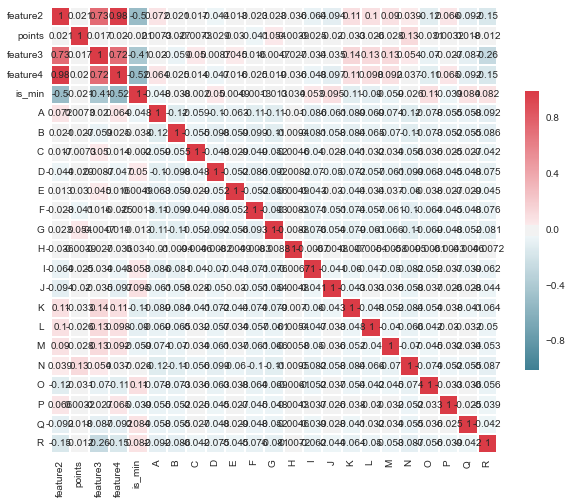

In [10]:
# Check the correlation between the is_min response variable and the remaining variables

corr = df.corr()
f, ax = plt.subplots(figsize = (10,10))
cmap = sns.diverging_palette(220,10, as_cmap = True)

sns.heatmap(corr,annot=True, cmap = cmap, square = True,
             linewidth =0.5, cbar_kws={"shrink": 0.5}, ax = ax)

In [11]:
# Fit a logistic regression model to each predictor. Report the training error rate.

from sklearn.linear_model import LogisticRegression

df = df.dropna()

training_error_rt = {}

for feature in features: 
    reduced = LogisticRegression(fit_intercept = True)
    reduced.fit(df.ix[:, df.columns == feature],df['is_min'])
    preds_train = reduced.predict(df.ix[:, df.columns == feature])
    training_error_rt[feature] = 1-reduced.score(df.ix[:, df.columns == feature],df['is_min'])

    
sortedSC = sorted(training_error_rt, key = training_error_rt.get)
sortedValues = sorted(training_error_rt.values())

print sortedSC
print sortedValues

['feature4', 'feature2', 'feature3', 'O', 'J', 'Q', 'H', 'A', 'C', 'B', 'G', 'F', 'I', 'K', 'M', 'L', 'P', 'R', 'E', 'N', 'D']
[0.20651779081294275, 0.20875819352298641, 0.2941184741826397, 0.30877248897960907, 0.3090302759023128, 0.31017625594960496, 0.31256664377831267, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803, 0.31324860736473803]


In [12]:
# Problem d, get the number of new advertisers in 3/18. This is done by a simple set difference operation which gives 
# all elements in 3/18 that are not in 2/12.

data1 = data.ix[data['date'] != "2016-03-18 12:00:00"]

ids_0212 = set(pd.unique(data1.id))
ids_0318 = set(pd.unique(data2.id))
 
print "New advertisers in 03/18/2016: " + str(len(ids_0318 - ids_0212))

New advertisers in 03/18/2016: 9947


In [13]:
# Problem e, get the number of advertisers that are missing from the 3/18 data. This is just the advertisers that are in 
# the 2/12 data but not the 3/18 data. 

print "Number of advertisers missing from 03/18/2016: " + str(len(ids_0212 - ids_0318))

Number of advertisers missing from 03/18/2016: 8727
